In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from draw import draw_dot
import torch 
%matplotlib inline

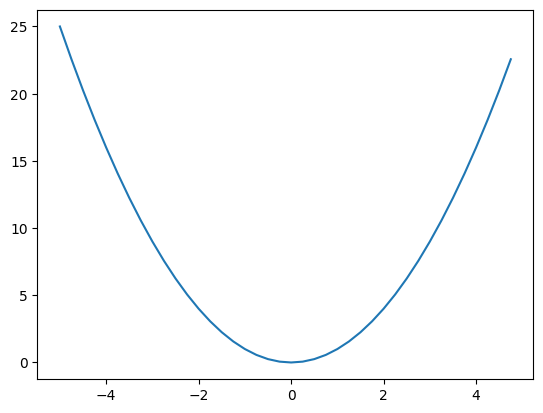

In [2]:
def f(x):
    return x**2 
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [3]:
h = 0.001
x = -1
(f(x+h) - f(x))/h

-1.998999999999973

In [4]:
h = -0.001
x = -1
(f(x+h) - f(x))/h

-2.0009999999996975

In [5]:
h = -0.001
x = 1
(f(x+h) - f(x))/h

1.998999999999973

In [6]:
def f(x):
    return 3*x**2 - 4*x +5

In [7]:
f(3.0)

20.0

In [8]:
xs = np.arange(-5,5,0.25)
ys = f(xs)

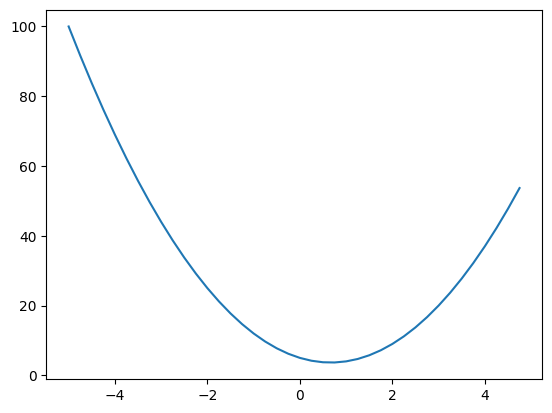

In [9]:
plt.plot(xs,ys)

In [10]:
h = 0.0000001
x = 2/3
(f(x+h) - f(x))/h


2.9753977059954195e-07

In [11]:
h = 0.0000001
x = -3
(f(x+h) - f(x))/h


-21.999999688659955

In [12]:
h = 0.0000001
x = 3
(f(x+h) - f(x))/h


14.000000305713911

In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other): 
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other): 
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
  

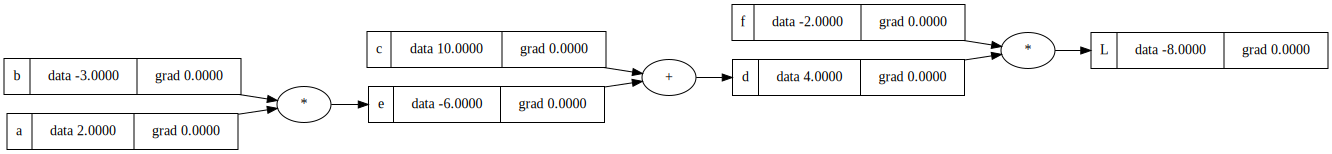

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dot(L)

$$
\text{Graph Above}\\\text{}\\
\frac{dL}{de} = \frac{dL}{dd}*\frac{dd}{de}
$$



$$
\text{Addition Partial Derivative}\\
a = d + c \\
\frac{da}{dd} = 1 \\\\
$$

$$
\text{Limit Proof}\\\text{}\\
L = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}\\ 
L = \frac{((d+h)+c)-(d+c)}{h}\\\text{}\\

L = \frac{h}{h}\\\text{}\\
L = 1 \\
$$

$$
\text{Multiplication Partial Derivative}\\
a = d * f \\
\frac{da}{dd} = f \\\\
$$

$$
\text{}\\
\text{Limit Proof}\\
L = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}\\ 
L = \frac{f(x+h)-f(x)}{h}\\
L = \frac{(d+h)f-df}{h}\\
L = \frac{df+hf-df}{h}\\
L = \frac{hf}{h}\\
L = f
$$

In [15]:
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.881373, label='b')

x1w1 =  x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'
o.backward()

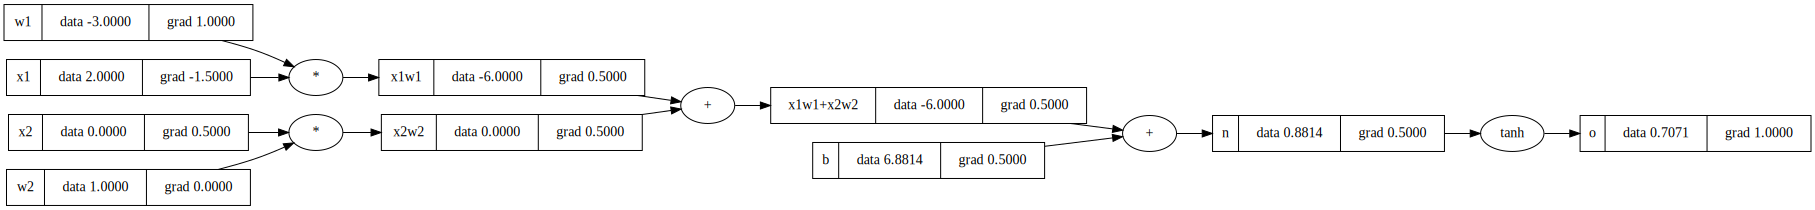

In [16]:
draw_dot(o)

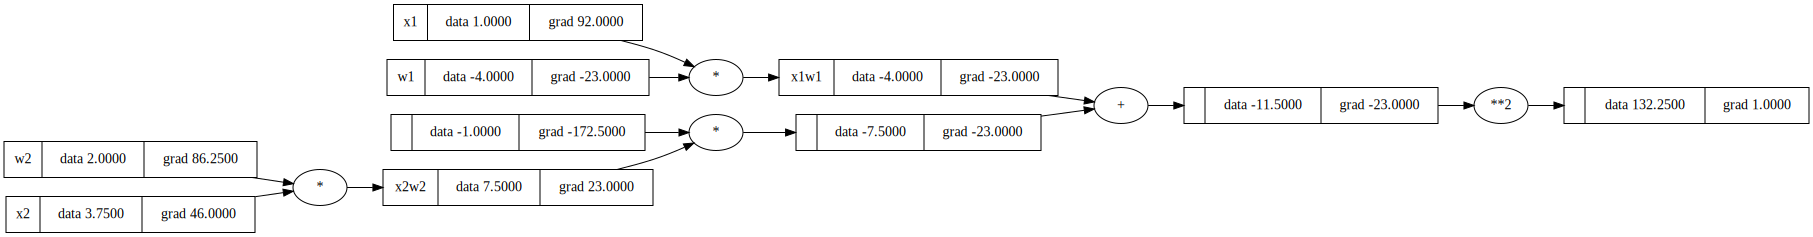

In [17]:
x1 = Value(1,label='x1')
w1 = Value(-4.0,label='w1')

x2 = Value(3.75,label='x2')
w2 = Value(2.0,label='w2')

x1w1 =  x1*w1 ; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'

loss = (x1w1-x2w2)**2
loss.backward()
draw_dot(loss)

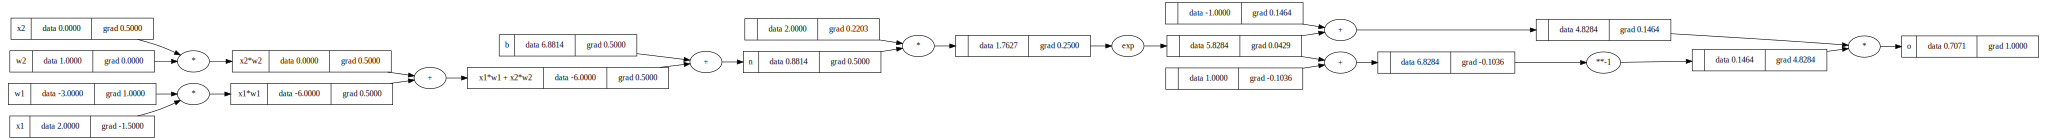

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [21]:
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
import random 

class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.027222959015959867)

In [24]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] 


In [25]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.027222959015959867),
 Value(data=-0.329992986453254),
 Value(data=-0.49366870241348537),
 Value(data=-0.03477812483232915)]

In [26]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=2.8312335562784883)

In [27]:
loss.backward()

In [28]:
n.layers[0].neurons[0].w[0].grad

0.8109001674703604

In [29]:
n.layers[0].neurons[0].w[0].data

-0.034192774005713744

In [30]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [31]:
n.layers[1].neurons[0].w[3].grad

2.538286988029885

In [32]:
n.layers[1].neurons[0].w[3].data

-0.5987242852557374

In [33]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=2.8312335562784883)

In [34]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 2.1673752564474063
1 0.31715410085573
2 0.10236967232938779
3 0.055731864007109666
4 0.04620805612363717
5 0.03995693353222981
6 0.035308868601915185
7 0.03166376424886332
8 0.02871316586527743
9 0.026270614150188887
10 0.024213281817550322
11 0.02245584607351476
12 0.020936796091048596
13 0.01961051706104881
14 0.018442404299631128
15 0.017405702627578935
16 0.01647938710400778
17 0.015646700466659988
18 0.014894119271526441
19 0.014210607930548326
